# Урок 1. Основы обучения нейронных сетей

## Домашнее задание

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

In [1]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
sns.set_theme()

In [3]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

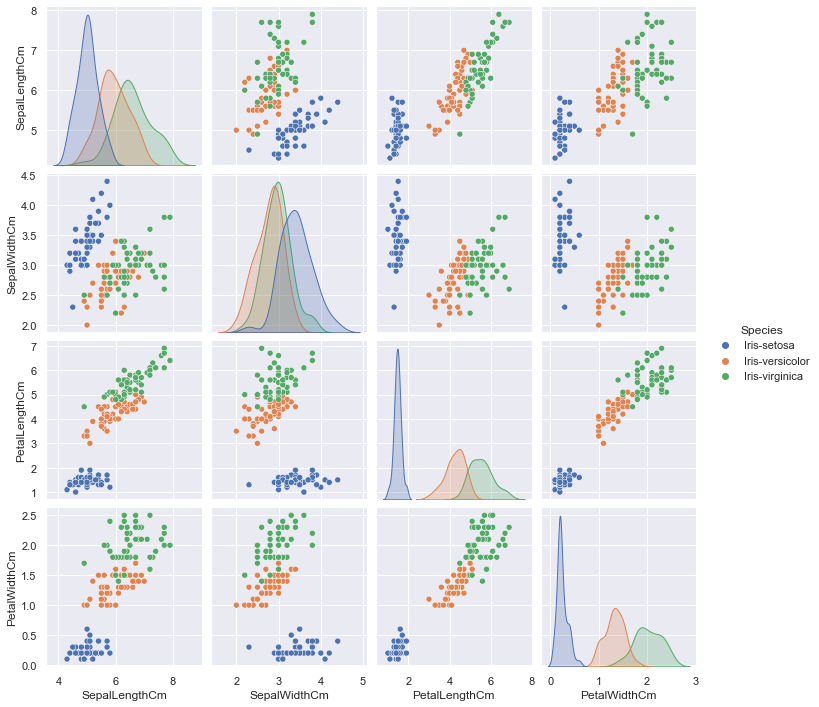

In [4]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

**Напишем класс нейросети DFF c произвольной конфигурацией скрытых слоев**

In [5]:
class NeuralNetwork:
    
    def __init__(self, n_neurons=(4, 2, 3), learning_rate=.05, n_epochs=10000, random_state=1):
        self.n_layers = len(n_neurons)
        self.n_neurons = n_neurons
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.random_state = random_state
        
        self.errors = []
        
        # initialization weights
        np.random.seed(self.random_state)
        self.w = []
        for i in range(self.n_layers - 1):
            self.w.append(2*np.random.random((self.n_neurons[i], self.n_neurons[i + 1])) - 1)
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def sigmoid_deriv(self, x):
        return (x)*(1 - (x))
    
    def feed_forward(self, X, copy=True):
        if copy:
            X = X.copy()
        
        # initialization layers
        layers = []
        for i in range(self.n_layers):
            layers.append(None)
        
        for idx in range(self.n_layers):
            if not idx:
                layers[idx] = X
            else:
                layers[idx] = self.sigmoid(np.dot(layers[idx - 1], self.w[idx - 1]))
        
        if copy:
            return layers[-1]
        else:
            return layers
    
    def back_propagation(self, y, layers):
        
        layers_error = []
        layers_delta = []
        for idx in range(self.n_layers - 1):
            layers_error.append(None)
            layers_delta.append(None)
            
        for idx in range(self.n_layers - 1):
            if not idx:
                layers_error[self.n_layers - 2 - idx] = y - layers[-1]
            else:
                layers_error[self.n_layers - 2 - idx] = layers_delta[self.n_layers - 1 - idx].dot(self.w[self.n_layers - 1 - idx].T)
            
            layers_delta[self.n_layers - 2 - idx] = layers_error[self.n_layers - 2 - idx] * self.sigmoid_deriv(layers[self.n_layers - 1 - idx])
        
        for idx in range(self.n_layers - 1):
            self.w[idx] += layers[idx].T.dot(layers_delta[idx]) * self.learning_rate
        
        return layers_error[-1]
        
    def fit(self, X, y):
        
        X = X.copy()
        y = y.copy()
        
        for i in range(self.n_epochs):
            out_layer_err = self.back_propagation(y, self.feed_forward(X, copy=False))
            self.errors.append(np.mean(np.abs(out_layer_err)))
                


In [6]:
def evaluate_errors(errors):
    plt.figure(figsize = (16,5))
    plt.plot(errors)
    plt.xlabel('Обучение')
    plt.ylabel('Ошибка')
    plt.show() # расскоментируйте, чтобы посмотреть 

def evaluate_out(y_pred, y, N=50):
    plt.figure(figsize = (16,5))
    plt.plot(y_pred[:N,1], 'r',label = 'Y new')
    plt.plot(y[:N,1],'g', label = 'Y train')
    plt.xlabel('№ примера')
    plt.ylabel('выход сети и целевой')
    plt.legend( )
    plt.show() # расскоментируйте, чтобы посмотреть 

**Визуализируем работу сети при разном количестве нейронов скрытого слоя**

Аккуратность нейронной сети при 2 нейронах скрытого слоя:83.58%
Аккуратность нейронной сети при 3 нейронах скрытого слоя:96.55%
Аккуратность нейронной сети при 4 нейронах скрытого слоя:96.65%
Аккуратность нейронной сети при 5 нейронах скрытого слоя:96.66%
Аккуратность нейронной сети при 6 нейронах скрытого слоя:96.78%
Аккуратность нейронной сети при 7 нейронах скрытого слоя:96.81%
Аккуратность нейронной сети при 8 нейронах скрытого слоя:96.71%


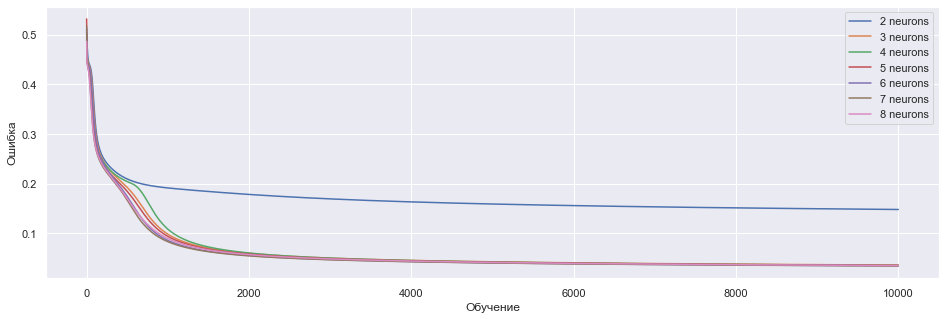

In [7]:
plt.figure(figsize = (16,5))
for i in np.arange(2, 9):
    net = NeuralNetwork(n_neurons=(4, i, 3))
    net.fit(X_train, y_train)
    y_train_pred = net.feed_forward(X_train)
    y_test_pred = net.feed_forward(X_test)
    
    plt.plot(net.errors, label=f'{i} neurons')

    layer_error_t = y_test - y_test_pred
    error_t = np.mean(np.abs(layer_error_t))
    accuracy_t = (1 - error_t) * 100
    print(f"Аккуратность нейронной сети при {i} нейронах скрытого слоя:" + str(round(accuracy_t,2)) + "%")
plt.legend()
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() # расскоментируйте, чтобы посмотреть 


Как видно, при добавлении одного нейрона качество предсказаний сети резко возрастает, но далее увеличение числа нейронов не дает большого прироста аккуратности. **Максимальная метрика на тесте достигается при 7 нейронах**

**Посмотрим, как меняется метрика на тесте при разном количестве эпох**

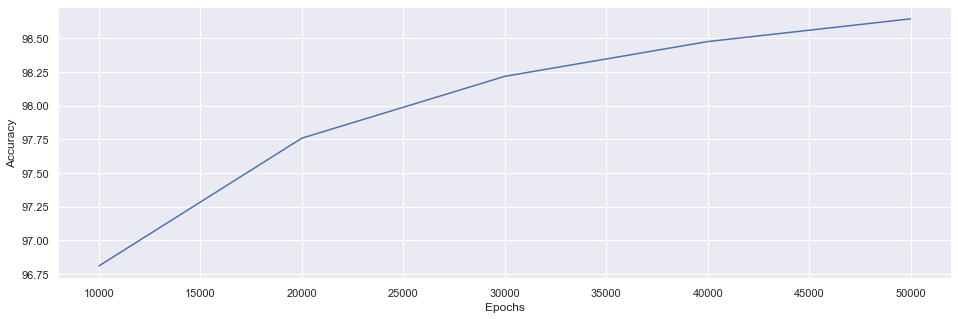

In [8]:
accuracy_list = []
for i in np.arange(10000, 50001, 10000):
    net = NeuralNetwork(n_neurons=(4, 7, 3), n_epochs=i)
    net.fit(X_train, y_train)
    y_train_pred = net.feed_forward(X_train)
    y_test_pred = net.feed_forward(X_test)

    layer_error_t = y_test - y_test_pred
    error_t = np.mean(np.abs(layer_error_t))
    accuracy_t = (1 - error_t) * 100
    accuracy_list.append(accuracy_t)

plt.figure(figsize = (16,5))
plt.plot(np.arange(10000, 50001, 10000), accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show() # расскоментируйте, чтобы посмотреть

Видно, что метрика неуклонно возрастает, то есть локальный минимум ошибки еще не достигнут. 

**Попробуем изменить скорость обучения вместо наращивания эпох**

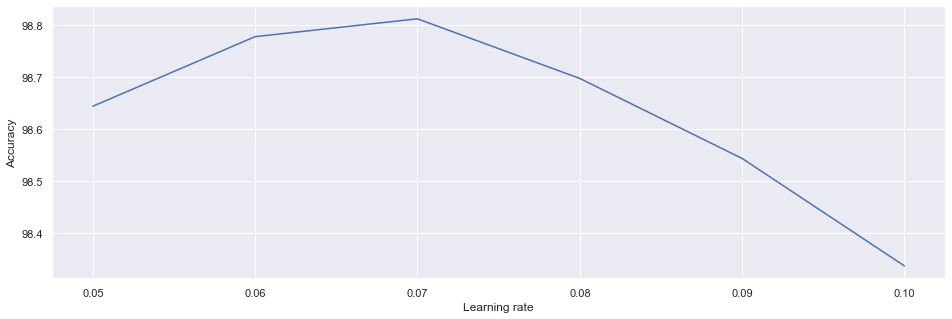

In [9]:
accuracy_list = []
for i in np.arange(.05, .11, .01):
    net = NeuralNetwork(n_neurons=(4, 7, 3), n_epochs=50000, learning_rate= i)
    net.fit(X_train, y_train)
    y_train_pred = net.feed_forward(X_train)
    y_test_pred = net.feed_forward(X_test)

    layer_error_t = y_test - y_test_pred
    error_t = np.mean(np.abs(layer_error_t))
    accuracy_t = (1 - error_t) * 100
    accuracy_list.append(accuracy_t)

plt.figure(figsize = (16,5))
plt.plot(np.arange(.05, .11, .01), accuracy_list)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.show() # расскоментируйте, чтобы посмотреть

Видна неоднорость нарастания метрики. Это может быть признаком нестабильного обучения нейросети (градиентный спуск перескакивает минимум). 

**Посмотрим процесс обучения с шагом больше 0.5**

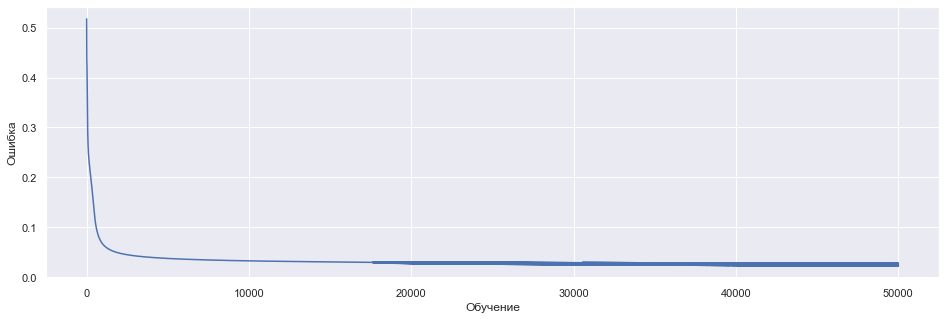

In [10]:
net = NeuralNetwork(n_neurons=(4, 7, 3), n_epochs=50000, learning_rate=.07)
net.fit(X_train, y_train)
evaluate_errors(net.errors)


Как видно, во время обучения есть небольшой "дребезг" - градиентный спуск скачет вокруг локального минимума. Но колебания вокруг минимума невелики, так что можно взять такую скорость обучения.

**Теперь попробуем добавить количество скрытых слоев**

Аккуратность нейронной сети при 1 скрытых слоев:98.81%
Аккуратность нейронной сети при 2 скрытых слоев:97.48%
Аккуратность нейронной сети при 3 скрытых слоев:96.23%


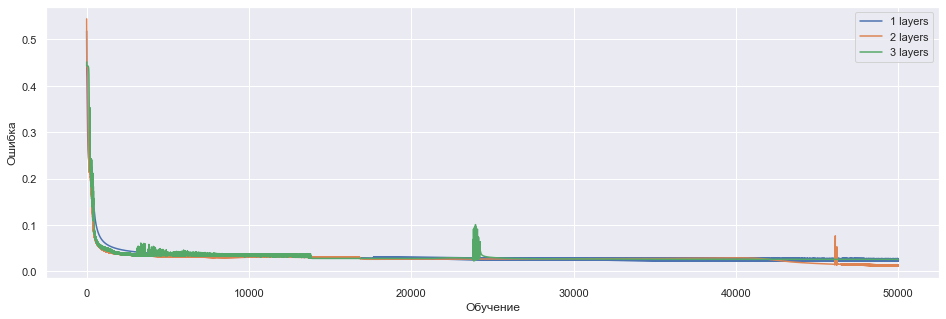

In [11]:
plt.figure(figsize = (16,5))
for i in np.arange(1, 4):
    
    if i == 1:
        n_neurons = (4, 7, 3)
    elif i == 2:
        n_neurons = (4, 7, 7, 3)
    elif i == 3:
        n_neurons = (4, 7, 7, 7, 3)
        
    net = NeuralNetwork(n_neurons=n_neurons, n_epochs=50000, learning_rate=.07)
    net.fit(X_train, y_train)
    y_train_pred = net.feed_forward(X_train)
    y_test_pred = net.feed_forward(X_test)
    
    plt.plot(net.errors, label=f'{i} layers')

    layer_error_t = y_test - y_test_pred
    error_t = np.mean(np.abs(layer_error_t))
    accuracy_t = (1 - error_t) * 100
    print(f"Аккуратность нейронной сети при {i} скрытых слоев:" + str(round(accuracy_t,2)) + "%")
plt.legend()
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() # расскоментируйте, чтобы посмотреть 

Как видно, добавление дополнительных скрытых слоев результата не принесло - сеть с двумя скрытыми слоями на трейне имеет наименьшую ошибку, но на тесте проигрывает однослойной модели. Можно сказать, что двухслойная модель переобучается.

Для трехслойной модели заданная скорость обучения является экстремальной. Но запуская ее с разной скоростью, мне не удалось избавиться от дребезга полностью, а также превзойти однослойную модель. Можно сказать, что пространство весов трехслойной модели слишком сложно устроено для такой задачи.

**Теперь посмотрим на выходной график**

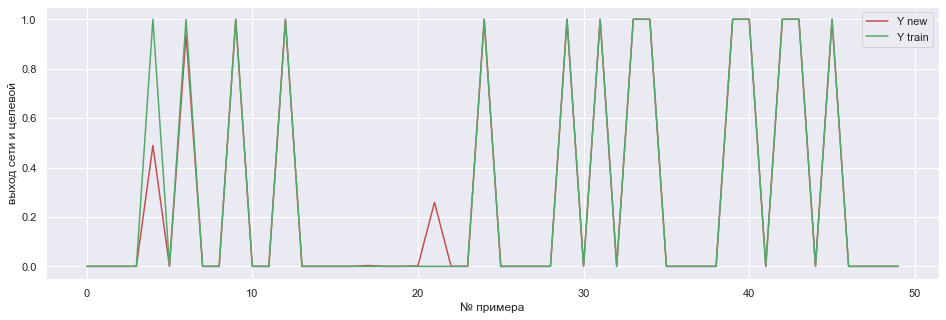

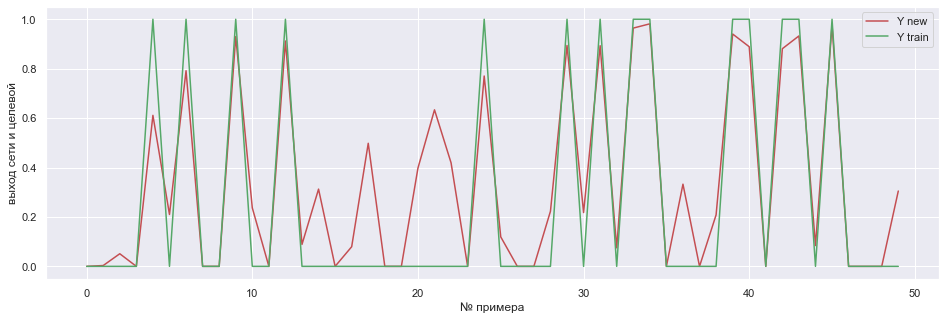

In [12]:
net = NeuralNetwork(n_neurons=(4, 7, 3), n_epochs=50000, learning_rate=.07)
net.fit(X_train, y_train)
y_train_pred = net.feed_forward(X_test)

net_simple = NeuralNetwork()
net_simple.fit(X_train, y_train)
y_train_pred_simple = net_simple.feed_forward(X_test)

evaluate_out(y_train_pred, y_test)
evaluate_out(y_train_pred_simple, y_test)

Видно, насколько сильно отличаются предсказания ненастроенной сети и настроенной